In [1]:
import numpy as np 
from keras.preprocessing.image import ImageDataGenerator 


# set the directory based on the folder where you saved dataset
train_data_dir = 'data/seg_train/seg_train' 
test_data_dir = 'data/seg_test/seg_test'

# training : 80%, val: 20%
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2)    

train_data = image_generator.flow_from_directory(batch_size=64,
                                                 directory=train_data_dir,
                                                 shuffle=True,
                                                 target_size=(64,64), 
                                                 subset="training",
                                                 class_mode='categorical')

val_data = image_generator.flow_from_directory(batch_size=64,
                                                 directory=train_data_dir,
                                                 shuffle=True,
                                                 target_size=(64,64), 
                                                 subset="validation",
                                                 class_mode='categorical')
test_gen = ImageDataGenerator(rescale=1./255)
test_data = test_gen.flow_from_directory(test_data_dir,
                                       target_size=(64,64), batch_size=64, shuffle=False)


print(train_data.classes)
print(val_data.classes)
print(train_data.class_indices)
print(test_data.classes)
class_names = np.unique(train_data.classes)


Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
[0 0 0 ... 5 5 5]
[0 0 0 ... 5 5 5]
{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
[0 0 0 ... 5 5 5]


In [2]:
print(train_data.class_indices)
print(val_data.classes)
print(train_data.samples)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
[0 0 0 ... 5 5 5]
11230


In [3]:
# Remove some unwanted warnings
import logging
logging.getLogger('tensorflow').disabled = True 
import pandas as pd 
import tensorflow as tf

### Building functions

In [4]:
### Split input-target from data generator
import math
def split_InOut(data, Genbatchsize):
    NSamples = data.samples
    NIter = math.ceil(NSamples/Genbatchsize)
    i = 0
    while i < NIter:
        if i == 0:
            x, y = data.next()
        else:
            x_temp, y_temp = data.next()
            x = np.append(x, x_temp, axis = 0)
            y = np.append(y, y_temp, axis = 0)
        i +=1
    return x, y


In [5]:
## Plotting history function
import matplotlib.pyplot as plt
def plot_history(data_list, label_list, title, ylabel):
    epochs = range(1, len(data_list[0]) + 1)
    for data, label in zip(data_list, label_list):
        plt.plot(epochs, data, label=label)
    plt.title(title)
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()

    plt.show()

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

def plot_cm_heatmap(model, x, ytrue, ypred, labels, plottitle):
    ytrue_value = np.argmax(ytrue, axis=1)
    ypred_value = np.argmax(ypred, axis=1)
    cm = confusion_matrix(ytrue_value, ypred_value)
    plt.figure(figsize=(16,10))
    dfcm = pd.DataFrame(cm, index = [i for i in labels],
                  columns = [i for i in labels])
    dfcm.index.name = 'True Labels'
    dfcm.columns.name = 'Predicted Labels'
    plt.title(plottitle, fontsize=14)
    sn.heatmap(dfcm, annot=True,  fmt="d")

In [7]:
## Plotting ROC
### PLOT ROC function

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
def plot_ROC(x, y, ypred, ROCtitle, n_classes):
    lw = 2
    y_score = ypred
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _= roc_curve(y[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), 
                                          y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
    mean_tpr /= n_classes
    
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(1)
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
             ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
             ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['blue',"purple", "pink",
                "red", "cyan","orange"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(ROCtitle)
    plt.legend(loc="lower right")
    plt.show()


### Preparing data

In [8]:
xtrain, ytrain = split_InOut(train_data,64)
xval, yval = split_InOut(val_data, 64)
xtest, ytest = split_InOut(test_data, 64)

In [9]:
print(xtrain.shape)
print(xval.shape)
print(xtest.shape)

(11230, 64, 64, 3)
(2804, 64, 64, 3)
(3000, 64, 64, 3)


In [10]:
class_dict = train_data.class_indices
labels = class_dict.keys()
labels 
input_shape = xtrain.shape[1:]

## Buidling CNNs

In [11]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import regularizers


def build_model(n_units = [64, 32]):    
    model = Sequential()
    # 1st layer
    model.add(layers.Conv2D(64, (3,3),
                            activation = 'relu',
                            padding = 'same',
                            input_shape = input_shape ))
    model.add(layers.MaxPooling2D((2,2)))
    # 2nd layer
    model.add(layers.Conv2D(64, (3,3),
                            padding = 'same',
                            activation = 'relu'))
    model.add(layers.MaxPooling2D((2,2)))
    # 3rd layer
    model.add(layers.Conv2D(64, (3,3),
                            padding = 'same',
                            activation = 'relu'))
    model.add(layers.MaxPooling2D((2,2)))
   
    # Add a Flatten layer to the model
    model.add(layers.Flatten())
    # Add 2 Dense layers with 64 and 32 units, relu activation
    model.add(layers.Dense(n_units[0], activation='relu'))
    model.add(layers.Dense(n_units[1], activation='relu'))
    # output layer 
    model.add(layers.Dense(6, activation='softmax'))         
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

### Baseline Model

In [12]:
model0 = build_model()
model0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 64)         0

In [13]:
#fit model on train data, and validate on validation data
history0 = model0.fit(xtrain, ytrain,
                      epochs = 20, 
                      batch_size = 32,
                      validation_data = (xval, yval),
                      verbose = 0)
print('end')

end


### Model performance on validation set

In [14]:
## Plotting loss and accuracy
### Get metric list
hist0_dict= history0.history
hist0_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

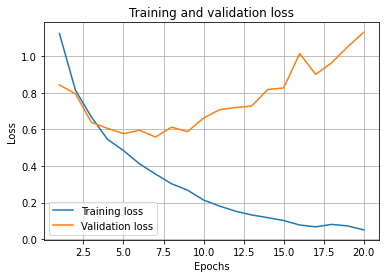

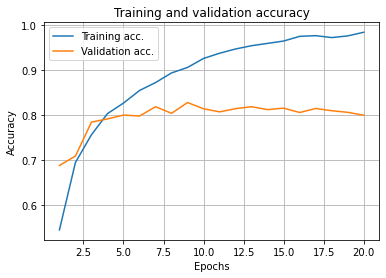

In [15]:
%matplotlib inline

acc = hist0_dict['accuracy']
val_acc = hist0_dict['val_accuracy']
loss = hist0_dict['loss']
val_loss = hist0_dict['val_loss']

plot_history(data_list=[loss, val_loss],
             label_list=['Training loss', 'Validation loss'],
             title='Training and validation loss',
             ylabel='Loss')
plot_history(data_list=[acc, val_acc],
             label_list=['Training acc.', 'Validation acc.'],
             title='Training and validation accuracy',
             ylabel='Accuracy')

#### model evaluation

In [16]:
yvalpred = model0.predict(xval)

88/88 [==============================] - 2s 25ms/step


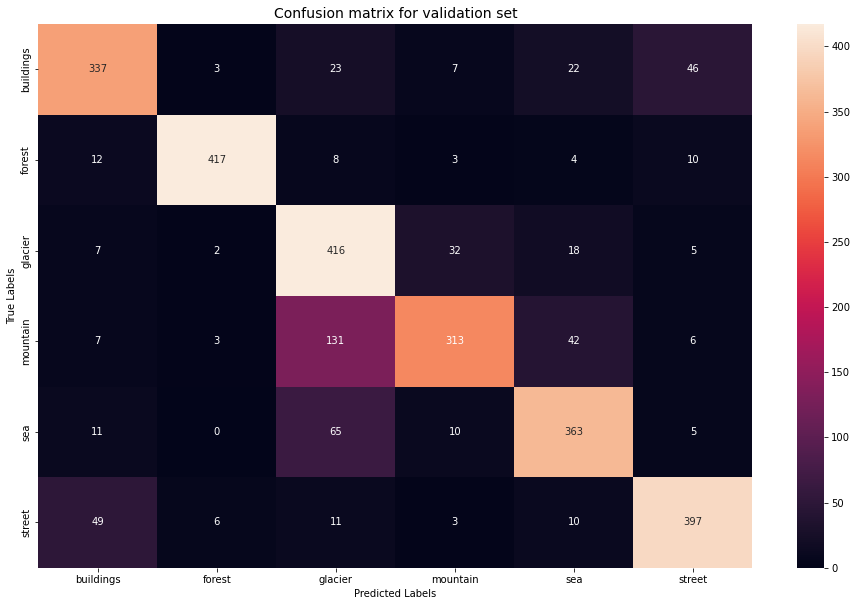

In [17]:
# Confustion matrix
plot_cm_heatmap(model = model0,
                x = xval,
                ytrue = yval, 
                ypred = yvalpred,
                labels = labels, 
                plottitle = "Confusion matrix for validation set")

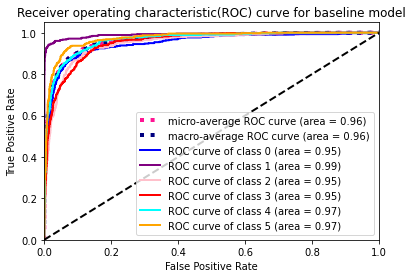

In [18]:
# ROC curve
plot_ROC(xval, yval, 
         yvalpred, 
         ROCtitle = 'Receiver operating characteristic(ROC) curve for baseline model',
         n_classes = 6)

In [19]:
# calculate model accuracy/loss

bl_loss, bl_acc = model0.evaluate(xval, yval)
print(bl_loss, bl_acc)

88/88 [==============================] - 2s 28ms/step - loss: 1.1301 - accuracy: 0.7999
1.1301063299179077 0.7999286651611328


In [20]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

def performance_measures(ytrue, ypred):
    ytrue_value = np.argmax(ytrue, axis=1)
    ypred_value = np.argmax(ypred, axis=1)
    cm=confusion_matrix(ytrue_value, ypred_value)
    FP = cm.sum(axis=0) - np.diag(cm)  
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)
    sensitivity = TP/(TP+FN)  
    specificity = TN/(TN+FP)
    f1 = f1_score(ytrue_value, ypred_value, average='weighted')
    
    return  np.mean(sensitivity), np.mean(specificity), f1



(0.8019457204850894, 0.9599355801741739, 0.8006560858702172)

## Optimizing and regulating model



In [21]:
# increasing network size
smallerModel = build_model(n_units=[16,8])
history_smaller = smallerModel.fit(xtrain, ytrain,
                                   epochs = 20, 
                                   batch_size = 32,
                                   validation_data = (xval, yval),
                                   verbose = 0)
print("end")


end


In [22]:
biggerModel = build_model(n_units=[256,128])
history_bigger = biggerModel.fit(xtrain, ytrain,
                                 epochs = 20, 
                                 batch_size = 32,
                                 validation_data = (xval, yval),
                                 verbose = 0)
print("end")

end


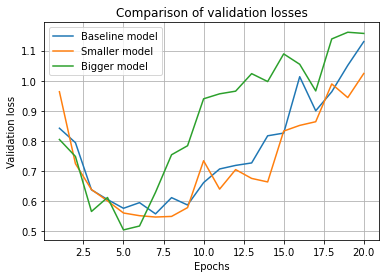

In [23]:
hist0_valloss = history0.history['val_loss']
smallerModel_valloss = history_smaller.history['val_loss']
biggerModel_valloss = history_bigger.history['val_loss']
plot_history(data_list=[hist0_valloss,
                        smallerModel_valloss, 
                        biggerModel_valloss],
             label_list=['Baseline model', 'Smaller model', 'Bigger model'],
             title='Comparison of validation losses',
             ylabel='Validation loss')


#### report on changing the number of units 
Changing the number of units does not show a big improvement in loss 

In [24]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers
input_shape = xtrain.shape[1:]
def build_model_add_layer(n_units = [64, 32, 16 ]):    
    model = Sequential()
    model.add(layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same',
                            input_shape = input_shape ))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(64, (3,3),padding = 'same',activation = 'relu'))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(64, (3,3),padding = 'same', activation = 'relu'))
    model.add(layers.MaxPooling2D((2,2)))
   
    model.add(layers.Flatten())
    model.add(layers.Dense(n_units[0], activation='relu'))
    model.add(layers.Dense(n_units[1], activation='relu'))
    model.add(layers.Dense(n_units[2], activation='relu'))
    # output layer 
    model.add(layers.Dense(6, activation='softmax'))         
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

In [26]:
ModelAdd1 = build_model_add_layer()
ModelAdd1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 8, 8, 64)        

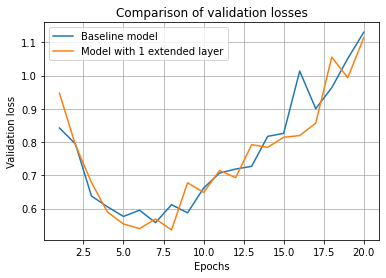

In [27]:

hist_ModelAdd1 = ModelAdd1.fit(xtrain, ytrain,
                               epochs = 20, 
                               batch_size = 32,
                               validation_data = (xval, yval),
                               verbose = 0)
hisModAdd_valloss = hist_ModelAdd1.history['val_loss']
plot_history(data_list=[hist0_valloss,
                        hisModAdd_valloss],
             label_list=['Baseline model', 'Model with 1 extended layer'],
             title='Comparison of validation losses',
             ylabel='Validation loss')

##### Adding weight Regularization

In [28]:
from tensorflow.keras import regularizers
def regularized_mod(n_units = [64, 32], regularizer = None):    
    model = Sequential()
    # 1st layer
    model.add(layers.Conv2D(64, (3,3),
                            activation = 'relu',
                            padding = 'same',
                            input_shape = input_shape ))
    model.add(layers.MaxPooling2D((2,2)))
    # 2nd layer
    model.add(layers.Conv2D(64, (3,3),
                            padding = 'same',
                            activation = 'relu'))
    model.add(layers.MaxPooling2D((2,2)))
    # 3rd layer
    model.add(layers.Conv2D(64, (3,3),
                            padding = 'same',
                            activation = 'relu'))
    model.add(layers.MaxPooling2D((2,2)))
   
    # Add a Flatten layer to the model
    model.add(layers.Flatten())
    # Add 2 Dense layers with 64 and 32 units, relu activation
    model.add(layers.Dense(n_units[0], 
                           kernel_regularizer=regularizer,
                           activation='relu'))
    model.add(layers.Dense(n_units[1], 
                           kernel_regularizer=regularizer,
                           activation='relu'))
    # output layer 
    model.add(layers.Dense(6, activation='softmax'))         
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

In [29]:
# Adding weight Regularization
from tensorflow.keras import regularizers
l2_model = regularized_mod(n_units = [64, 32], 
                           regularizer = regularizers.l2(0.001))
hist_l2= l2_model.fit(xtrain, ytrain,
                      epochs = 20,
                      batch_size = 32,
                      validation_data = (xval, yval),
                      verbose = 0)
print("end")


end


In [30]:
from tensorflow.keras import backend as K

def l2_reg(weight_matrix, lmbd):
    return lmbd * K.sum(K.square(weight_matrix))

    
l2custom = regularized_mod(n_units = [64, 32], 
                           regularizer=(lambda w: l2_reg(w, 0.001)))
hist_l2custom = l2custom.fit(xtrain, ytrain,
                             epochs=20,
                             batch_size=32,
                             validation_data=(xval, yval),
                             verbose=0 )
print("end")     

end


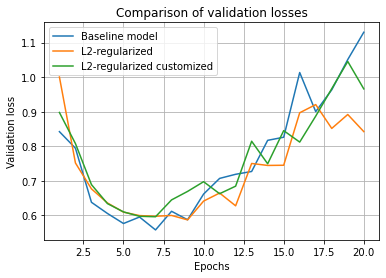

In [31]:
l2_valloss = hist_l2.history['val_loss']
l2custom_valloss = hist_l2custom.history['val_loss']

plot_history(data_list=[hist0_valloss,
                        l2_valloss, 
                        l2custom_valloss],
             label_list=['Baseline model', 'L2-regularized', 
                        'L2-regularized customized'],
             title='Comparison of validation losses',
             ylabel='Validation loss')

In [32]:
## Optimize model with drop out
def dpt_model(n_units = [64, 32], dropout_rate = 0.4):    
    model = Sequential()
    # 1st layer
    model.add(layers.Conv2D(64, (3,3),
                            activation = 'relu',
                            padding = 'same',
                            input_shape = input_shape )
             )
    model.add(layers.MaxPooling2D((2,2)))
    # 2nd layer
    model.add(layers.Conv2D(64, (3,3),
                            padding = 'same',
                            activation = 'relu')
             )
    model.add(layers.MaxPooling2D((2,2)))
    # 3rd layer
    model.add(layers.Conv2D(64, (3,3),
                            padding = 'same',
                            activation = 'relu')
             )
    model.add(layers.MaxPooling2D((2,2)))
   
    # Add a Flatten layer to the model
    model.add(layers.Flatten())
    # Add 2 Dense layers with 64 and 32 units, relu activation
    model.add(layers.Dense(n_units[0], activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(n_units[1], activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    # output layer 
    model.add(layers.Dense(6, activation='softmax'))         
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

In [33]:
dropout_model = dpt_model(n_units = [64, 32], dropout_rate = 0.4)
dropout_hist = dropout_model.fit(xtrain, ytrain,  
                                 epochs = 20, 
                                 batch_size=32,
                                 validation_data=(xval, yval),
                                 verbose=0 )
print("end")      

end


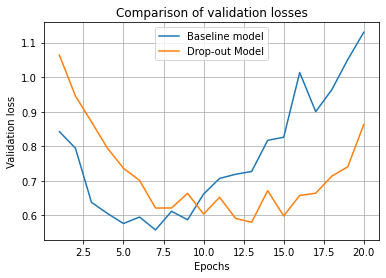

In [34]:
dpt_valloss = dropout_hist.history['val_loss']
plot_history(data_list=[hist0_valloss,
                        dpt_valloss],
             label_list=['Baseline model', 'Drop-out Model'],
             title='Comparison of validation losses',
             ylabel='Validation loss')

In [37]:
smlM_loss, smlM_acc = smallerModel.evaluate(xval, yval)
bgM_loss, bgM_acc = biggerModel.evaluate(xval, yval)
addM_loss, addM_acc = ModelAdd1.evaluate(xval, yval)
l2_loss, l2_acc = l2_model.evaluate(xval, yval)
l2cus_loss, l2cus_acc = l2custom.evaluate(xval, yval)
dpt_loss, dpt_acc = dropout_model.evaluate(xval, yval)


88/88 [==============================] - 2s 27ms/step - loss: 0.8630 - accuracy: 0.7853


#### Final model

In [145]:
from tensorflow.keras import regularizers
def finalModel(n_units = [64, 32], 
                regularizer = None, 
                dropout_rate = 0.4):    
    model = Sequential()
    # 1st layer
    model.add(layers.Conv2D(64, (3,3),
                            activation = 'relu',
                            padding = 'same',
                            input_shape = input_shape ))
    model.add(layers.MaxPooling2D((2,2)))
    # 2nd layer
    model.add(layers.Conv2D(64, (3,3),
                            padding = 'same',
                            activation = 'relu'))
    model.add(layers.MaxPooling2D((2,2)))
    # 3rd layer
    model.add(layers.Conv2D(64, (3,3),
                            padding = 'same',
                            activation = 'relu'))
    model.add(layers.MaxPooling2D((2,2)))
   
    # Add a Flatten layer to the model
    model.add(layers.Flatten())
    # Add 2 Dense layers with 64 and 32 units, relu activation
    model.add(layers.Dense(n_units[0], 
                           kernel_regularizer=regularizer,
                           activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(n_units[1], 
                           kernel_regularizer=regularizer,
                           activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    # output layer 
    model.add(layers.Dense(6, activation='softmax'))         
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

In [146]:
xtrainval = np.append(xtrain, xval, axis = 0)
ytrainval = np.append(ytrain, yval, axis = 0)
print(xtrainval.shape)
print(ytrainval.shape)

(14034, 64, 64, 3)
(14034, 6)


In [147]:
finalMod = finalModel(n_units = [64, 32], 
                       regularizer = regularizers.l2(0.001),
                       dropout_rate = 0.4)
finalMod.summary()
his_final = finalMod.fit(xtrainval, ytrainval, 
                         epochs = 7, 
                         batch_size=32,
                         validation_data=(xtest, ytest),
                         verbose=0 )

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_66 (Conv2D)          (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_66 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_67 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_67 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_68 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_68 (MaxPoolin  (None, 8, 8, 64)       

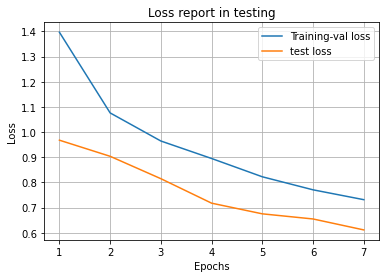

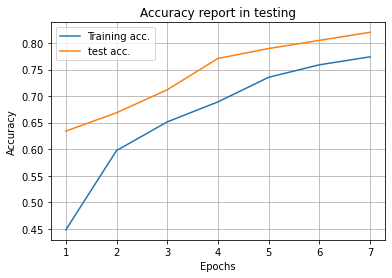

In [148]:
# Plot loss and acc 

%matplotlib inline

fn_acc = his_final.history['accuracy']
test_acc = his_final.history['val_accuracy']
fn_loss = his_final.history['loss']
test_loss = his_final.history['val_loss']

plot_history(data_list=[fn_loss, test_loss],
             label_list=['Training-val loss', 'test loss'],
             title='Loss report in testing',
             ylabel='Loss')
plot_history(data_list=[fn_acc, test_acc],
             label_list=['Training acc.', 'test acc.'],
             title='Accuracy report in testing',
             ylabel='Accuracy')

In [149]:
fn_loss, fn_acc = finalMod.evaluate(xtest, ytest)



94/94 [==============================] - 3s 28ms/step


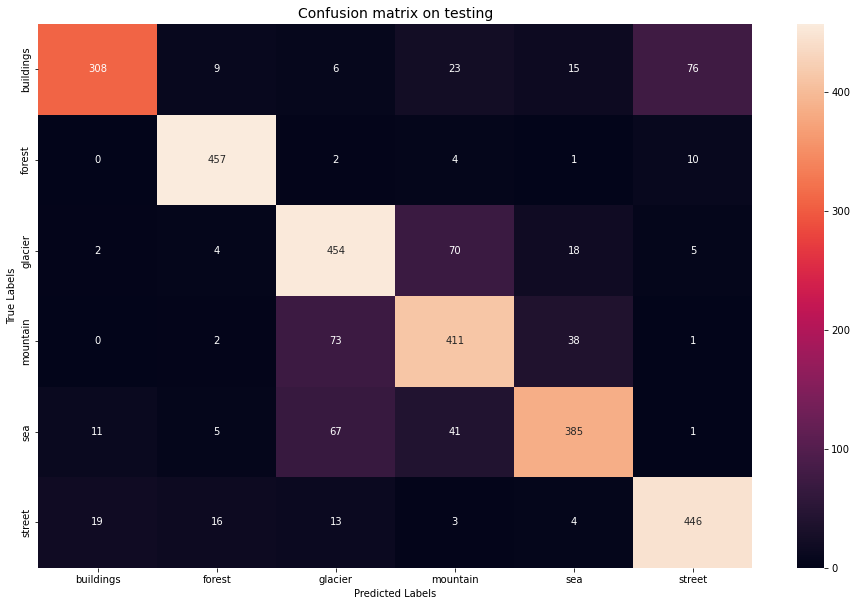

In [151]:
## confusion matrix
plot_cm_heatmap(model = finalMod,
                x = xtest,
                ytrue = ytest, 
                ypred = ytestpred,
                labels = labels, 
                plottitle = "Confusion matrix on testing")

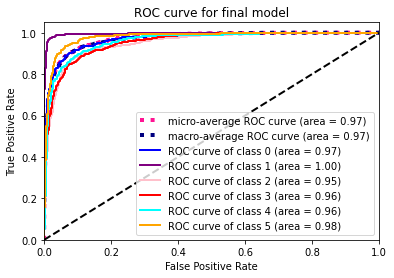

In [152]:

# ROC curve
plot_ROC(xtest, ytest, 
         ytestpred, 
         ROCtitle = 'ROC curve for final model',
         n_classes = 6)